In [1]:
import os, sys
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from thop import profile
torch.__version__

'1.10.1+cu113'

In [2]:
RANDOM_STATE = 111
BATCH_SIZE = 16
EPOCHS = 10
TEST_SIZE = 0.15
LR = 1e-4

In [3]:
dir_path = './data/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)

print(f'資料共{len(data_path)}筆')

資料共239筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (256, 256))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共203筆
驗證資料共36筆
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.43 ms


In [7]:
class imageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [8]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 1.21 s, total: 14.5 s
Wall time: 14.5 s


### UNet
- https://github.com/qubvel/segmentation_models.pytorch
- https://ithelp.ithome.com.tw/articles/10240314

In [9]:
# set the DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=36, shuffle = False)

# choose GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# pre-trained model
# model = UNet(pretrained=True).to(device)

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3                       # model output channels (number of classes in your dataset)
).to(device)

# Define loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [10]:
# Training loop
acc_history = []
loss_history = []
timing_history = np.zeros((EPOCHS, 1))

for epoch in range(EPOCHS):
    train_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        inputs, label = data
        inputs = inputs.to(device)
        label = label.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.to(device))
        # 將三維壓縮為一維
        avg_pool = nn.AdaptiveMaxPool2d(1)
        squeeze_outputs = avg_pool(outputs).squeeze()
        
        # calculate loss
        loss = criterion(squeeze_outputs, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(squeeze_outputs, 1)
        _, corrected = torch.max(label.data, 1)
        total += label.size(0)
        correct += (predicted == corrected).sum().item()

    loss_history.append(train_loss)
    acc_history.append(100*correct/total)
    print(f"--------------------Epoch {epoch+1}--------------------")
    print(f"Train_accuracy: {(100*correct/total):.2f}% | Train_loss: {train_loss:.4f}")
    
# Evaluate the model on the test dataset
correct = 0
total = 0
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)
timing = 0
with torch.no_grad():
    for data in test_loader:
        inputs, label = data
        inputs = inputs.to(device)
        label = label.to(device)
        
        # inference
        starter.record()
        outputs = model(inputs)
        ender.record()
        
        # 將三維壓縮為一維
        avg_pool = nn.AdaptiveMaxPool2d(1)
        squeeze_outputs = avg_pool(outputs).squeeze()
        
        # check correct
        _, predicted = torch.max(squeeze_outputs, 1)
        _, corrected = torch.max(label.data, 1)
        total += label.size(0)
        correct += (predicted == corrected).sum().item()
        
        # record time
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timing = curr_time
        
print(f'Accuracy on the test images: {(100*correct/total):.2f}%')
print(f'Inference time: {timing:.4f} milliseconds')

--------------------Epoch 1--------------------
Train_accuracy: 59.11% | Train_loss: 12.7205
--------------------Epoch 2--------------------
Train_accuracy: 66.01% | Train_loss: 11.4353
--------------------Epoch 3--------------------
Train_accuracy: 59.11% | Train_loss: 11.2100
--------------------Epoch 4--------------------
Train_accuracy: 66.01% | Train_loss: 11.2096
--------------------Epoch 5--------------------
Train_accuracy: 68.97% | Train_loss: 9.5337
--------------------Epoch 6--------------------
Train_accuracy: 72.41% | Train_loss: 8.2719
--------------------Epoch 7--------------------
Train_accuracy: 79.80% | Train_loss: 7.5258
--------------------Epoch 8--------------------
Train_accuracy: 82.27% | Train_loss: 6.9230
--------------------Epoch 9--------------------
Train_accuracy: 87.19% | Train_loss: 5.3165
--------------------Epoch 10--------------------
Train_accuracy: 82.76% | Train_loss: 5.1239
Accuracy on the test images: 55.56%
Inference time: 36.5404 milliseconds


### 使用pre-trained的model

### Result

In [11]:
class plot():
    def __init__(self, acc_history, loss_history):
        self.acc_history = acc_history
        self.loss_history = loss_history
        
    def call(self, index):
        if index == 0:
            self.plot_acc()
        else:
            self.plot_loss()
        
    def plot_acc(self):
        plt.plot(self.acc_history)
        # plt.plot(self.result['accuracy'])
        # plt.plot(self.result['val_accuracy'])
        plt.title('Accuracy History')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train'], loc='upper left')
        # plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def plot_loss(self):
        plt.plot(self.loss_history)
        # plt.plot(self.result['loss'])
        # plt.plot(self.result['val_loss'])
        plt.title('Loss History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train'], loc='upper left')
        # plt.legend(['train', 'val'], loc='upper left')
        plt.show()

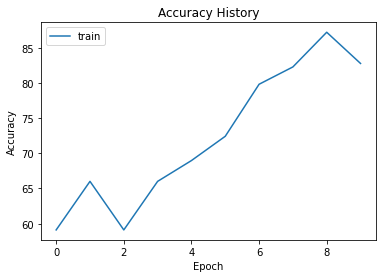

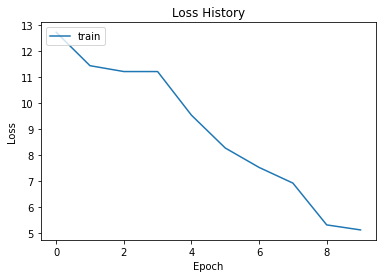

In [12]:
myPlot = plot(acc_history, loss_history)
myPlot.call(0)
myPlot.call(1)

### Flops and macs
- https://github.com/zhijian-liu/torchprofile
- FLOPs（浮點運算次數）：模型計算過程中所執行的浮點運算（加法和乘法）的總次數。FLOPs通常用來估計模型的計算需求和效能，尤其是在硬體加速器的應用中。
- MACs（乘加運算次數）：則是指在模型計算過程中執行的乘法和加法運算的總次數。由於在許多計算中，乘法和加法操作通常是同時進行的，因此MACs可以更好地反映模型的計算需求。

In [13]:
inputs = torch.randn(BATCH_SIZE, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(inputs, ))
print(f'FLOPs = {(flops/1000**3)}G')
print(f'Params = {(params/1000**2)}M')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs = 96.390905856G
Params = 24.436659M
